# <font color="#114b98">Conception d'une application au service de la santé publique</font>

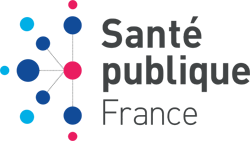

L'agence **"Santé publique France"** a lancé un appel à projets pour trouver des **idées innovantes d’applications en lien avec l'alimentation**.

Nous allons dans un premier temps **traiter le jeu de données afin de repérer des variables pertinentes** pour les traitements à venir et **automatiser ces traitements** pour éviter de répéter ces opérations.

## <font color="#00afe6">Sommaire</font>
[1.1. Colonnes et lignes vides / Doublons](#section_1)     
[1.2. Variables redondantes](#section_2)     
[1.3. Les pays de l'analyse](#section_3)     
[1.4. Les catégories de produits](#section_4)          
[1.5. Compléter les valeurs manquantes ou aberrantes](#section_5)     
[1.6. Calcul des Nutri-Scores manquants](#section_6)     

## <font color="#00afe6">1. Nettoyage des données</font>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Le jeu de données téléchargé en CSV sur le site [Open Food Facts](https://world.openfoodfacts.org/) est importé dans le Notebook via la méthode `read_csv` de la librairie `pandas`

In [ ]:
datas = pd.read_csv("../input/enopenfoodfactsorgproducts/en.openfoodfacts.org.products.csv",
                    sep='\t', low_memory=False)

Affichons à présent quelques lignes au hasard du dataset puis regardons sa `shape`

In [ ]:
datas.sample(5)

In [ ]:
print ("Le dataset compte {} lignes et {} variables".format(datas.shape[0], datas.shape[1]))

### <font color="#ea1c60" id="section_1">1.1. Colonnes et lignes vides / Doublons</font>
Regardons à présent les **variables qui comptent le plus de valeurs null**:

In [ ]:
def null_factor(df, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [ ]:
full_null_rate = null_factor(datas, 100)
full_null_rate

Nous allons regarder le taux de remplissage des variables graphiquement et fixer un **seuil de suppression à 25% de taux de remplissage** :

In [ ]:
filling_features = null_factor(datas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [ ]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
datas = datas[features_to_conserve].sort_values(["created_datetime","last_modified_datetime"], ascending=True)
datas.sample(5)

155 features sur 184 ont un taux de valeurs nulles supérieur à 50%, ce qui représente une très grosse part de données manquantes. **La majeure partie de ces variables ne peuvent pas être recalculées** puisqu'il s'agit de mesures physico-chimiques directes sur les produits.

Il reste à présent 50 features dans notre dataset. Pour la suite des analyses, nous aurons besoin d'un minimum d'informations sur **les nutriments** des produits. Ces données sont **suffixées avec** `_100g`. Nous allons donc **conserver les lignes pour lesquelles au moins une de ces features est complétée** :

In [ ]:
def search_componant(df, suffix='_100g'):
  componant = []
  for col in df.columns:
      if '_100g' in col: componant.append(col)
  df_subset_columns = df[componant]
  return df_subset_columns

In [ ]:
df_subset_nutients = search_componant(datas,'_100g')
df_subset_nutients.head()

In [ ]:
print('Lignes nutriments (_100g) vides: {}'.format(df_subset_nutients.isnull().all(axis=1).sum()))

In [ ]:
datas = datas[df_subset_nutients.notnull().any(axis=1)]
datas.shape

Notre jeu de données est à présent débarassé des lignes et colonnes peu complétées. Nous allons à présent **rechercher et supprimer les doublons**.

In [ ]:
# Suppression des doublons en fonction du code
datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)

In [ ]:
datas[(datas["product_name"].isnull()==False) 
      & (datas["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

In [ ]:
datas = datas[(datas["product_name"]!="🤬") 
              & (datas["brands"]!="🤬")]

In [ ]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
datas = datas[(~datas.duplicated(["product_name","brands"],keep="last")) 
      | ((datas['product_name'].isnull()) & (datas['brands'].isnull()))]

In [ ]:
datas.shape

### <font color="#ea1c60" id="section_2">1.2. Variables redondantes</font>

Certaines variables dans le dataset sont en réalité des variables redondantes. C'est par exemple le cas des variables suffixées par `_tags` ou `_en` qui ne font que reprendre d'autres features traduites ou simplifiées.

C'est par exemple de cas des catégories produits :

In [ ]:
category_columns = ['categories','categories_tags','categories_en']
datas[datas[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous allons donc, lorsque la colonne suffixée `_en` existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant `_tags` :

In [ ]:
def search_redundant_col(df):
  redundant_columns = []
  for col in df.columns:
    if "_en" in col:
      en = col.replace('_en','')
      tags = col.replace('_en','_tags')
      print("{:<20} 'Sans suffixe' -> {} ; 'Suffixe _tags' -> {}".format(col,
                                                                        en in df.columns, tags in df.columns))
      if en in df.columns : 
        redundant_columns.append(en)
      if tags in df.columns : 
        redundant_columns.append(tags)
  
    if '_tags' in col:
      tags_2 = col.replace('_tags','')
      print("{:<20} 'Suffixe _tags' -> {} ;".format(tags_2, tags_2 in df.columns))
      if tags_2 in df.columns :
        redundant_columns.append(col)

  return redundant_columns

In [ ]:
datas.drop(search_redundant_col(datas), axis=1, inplace=True)

**Les dates également comportent une certaine redondance**. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [ ]:
datas['created_datetime'] = pd.to_datetime(datas['created_t'], unit='s')
datas['last_modified_datetime'] = pd.to_datetime(datas['last_modified_t'], unit='s')
datas = datas.drop(['created_t','last_modified_t'], axis=1)
datas.head()

Nous pouvons à présent regarder la **distribution des contributions par année** :

In [ ]:
add_per_year = datas[['created_datetime', 'code']].groupby(by=datas['created_datetime'].dt.year).nunique()

fig=plt.figure(figsize=(12,8))

sns.set_style("whitegrid")
sns.barplot(data=add_per_year, x=add_per_year.index, y='code', color='#00afe6')

plt.title("Evolution des créations de produits dans la base par année", fontdict=font_title)
plt.xlabel("Année de création")
plt.ylabel("Nombre de créations")
plt.show()

Les années de 2012 à 2016 sont visiblement bien moins représentées que les années 2017 à 2019. La mise en place du Nutri-Score a été votée dans le cadre de la **loi Santé de 2016**.

In [ ]:
datas.shape

A présent, notre dataset compte 40 variables qui ne contienent plus de redondance et 1 124 710 lignes. Nous allons maintenant nous intéresser à une variable importante : le pays.

### <font color="#ea1c60" id="section_3">1.3. Les pays de l'analyse</font>

Regardons tout d'abord le nombre de pays représentés *(s'il est trop élevé, c'est que des erreurs existent)*

In [ ]:
countries = datas.groupby(by="countries_en").nunique()

In [ ]:
countries[['code']].head()

Plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte pour visualiser tout nos pays :

In [ ]:
def split_words(df, column = 'countries_en'):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

In [ ]:
#Liste contenant tous les pays du jeu de données (bons ou mauvais)
list_countries = split_words(datas, 'countries_en')

In [ ]:
print("Nombre de pays représentés : {}".format(len(list_countries)))

Nous allons charger une **base de données des pays, en Anglais**, pour déterminer les pays qui ne matchent pas *(mauvaise orthographe ou autre)*.

In [ ]:
df_countries = pd.read_csv("../input/enopenfoodfactsorgproducts/countries-en.csv",
                        sep=",", header=None, index_col = 0).rename(columns={0:"index", 1:"country_id", 2:"country_code_2", 3:"country_code_3", 4:"country_fr", 5:"country_en"})
df_countries.head()

In [ ]:
df_countries = pd.merge(pd.DataFrame(list_countries, columns=["countries_dataset"]),df_countries, how="left", 
         left_on="countries_dataset", right_on="country_en")

In [ ]:
false_country_list = list(df_countries[df_countries.isnull().sum(axis=1)>0].countries_dataset)
false_country_list[0:15]

puis nous allons **supprimer ces pays "fantômes" de la base de données** :

In [ ]:
for index, countries in datas['countries_en'].str.split(',').items():
  if isinstance(countries, float):
    continue
  country_name = []
  found = False
  for country in countries:
    if country in false_country_list:
      found = True
    else:
      country_name.append(country)
  if found:
    datas.loc[index, 'countries_en'] = ','.join(country_name)

In [ ]:
print("Nouveau nombre de pays représentés : {}".format(len(split_words(datas, 'countries_en'))))

Le nombre de pays représenté est à présent plus cohérent et la perte d'informations est limitée. Il nous reste à présent à **compléter les valeurs nulles pour cette variable**.

In [ ]:
datas['countries_en'] = np.where((datas['countries_en'].isnull()==True), "unknown", 
                                 np.where(datas['countries_en'] == "", "unknown", datas['countries_en']))

Nous pouvons également regarder quels sont les **pays les plus représentés** :

In [ ]:
def top_words(df, column="countries_en", nb_top=10):
  count_keyword = dict()
  for index, col in df[column].iteritems():
    if isinstance(col, float):
      continue
    for word in col.split(','):
      if word in count_keyword.keys():
        count_keyword[word] += 1
      else :
        count_keyword[word] = 1
  
  keyword_top = []
  for k,v in count_keyword.items():
    keyword_top.append([k,v])
  keyword_top.sort(key = lambda x:x[1], reverse = True)

  return keyword_top[:nb_top]

In [ ]:
df_top_countries = pd.DataFrame(top_words(df=datas, column="countries_en", nb_top=10), 
                                columns=["Keyword","count"])
df_top_countries

**La France et les Etats-Unis sont massivement représentés** dans le Dataset. Le 10ème Pays représenté en terme de volume ne compte plus que 5 500 entrées - soit 100 fois moins que le 1er. Cette différence devra être prise en compte dans les futurs modèles développés. 

### <font color="#ea1c60" id="section_4">1.4. Les catégories de produits</font>

Intéressons nous à présent à la catégorisation des produits. 4 variables représentent cette catégorisation de manière plus ou moins précise : `categories_en`, `main_category_en`, `pnns_groups_1`, `pnns_groups_2`.

In [ ]:
datas[['categories_en','pnns_groups_1','pnns_groups_2','main_category_en',]].sample(10)

Nous allons regarder le **nombre total de catégories représentées** :

In [ ]:
categories = split_words(df = datas, column = 'categories_en')
print("{} catégories sont représentées dans le jeu de données.".format(len(categories)))

Ici également, nous allons regarder les **catégories les plus représentées**, après avoir remplacé les valeurs nulles et complété les valeurs inconnues des pnns avec la catégorie principale :

In [ ]:
datas['categories_en'] = np.where((datas['categories_en'].isnull()==True), "unknown", 
                                 np.where(datas['categories_en'] == "", "unknown", datas['categories_en']))
datas['main_category_en'] = np.where((datas['main_category_en'].isnull()==True), "unknown", 
                                 np.where(datas['main_category_en'] == "", "unknown", datas['main_category_en']))
datas['pnns_groups_1'] = np.where((datas['pnns_groups_1'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_1'] == "", "unknown", datas['pnns_groups_1']))
datas['pnns_groups_2'] = np.where((datas['pnns_groups_2'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_2'] == "", "unknown", datas['pnns_groups_2']))

In [ ]:
df_top_categories = pd.DataFrame(top_words(df=datas, column="categories_en", nb_top=10), 
                                 columns=["Keyword","count"])
df_top_categories

Il existe donc également une grande disparité dans les catégories représentées et les "unknown", les catégories inconnues l'emportent. 

Pour une meilleure visualisation, nous allons représenter le top 100 des catégories dans un nuage de mots grâce à la librairie `WordCloud` :

In [ ]:
from wordcloud import WordCloud

def plot_world_cloud(df=datas,column="categories_en",nb_top=100):
  fig = plt.figure(1, figsize=(20,15))
  ax1 = fig.add_subplot(1,1,1)

  words = dict()
  trunc_occurences = top_words(df=df, column=column, nb_top=nb_top)
  for s in trunc_occurences:
    words[s[0]] = s[1]

  word_cloud = WordCloud(width=900,height=500, normalize_plurals=False,
                        background_color="white")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des {} meilleures {}\n".format(nb_top, column), fontsize=22)
  plt.show()

In [ ]:
plot_world_cloud(df=datas,column="categories_en",nb_top=100)

Passons à présent aux variables `pnns_groups_1` et `pnns_groups_2` qui nous apporteront des informations plus précises :

In [ ]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

In [ ]:
pnns_groups_1

On voit ici que certaines catégories sont présentes plusieurs fois mais orthographiées différement :
- 'Cereals and potatoes' et 'cereals-and-potatoes'
- 'fruits-and-vegetables' et 'Fruits and vegetables'
- ...

Nous allons donc corriger le problème en passant le texte en miniscule et en remplaçant les caractères spéciaux par un espace :

In [ ]:
datas["pnns_groups_1"] = datas["pnns_groups_1"].str.lower().str.replace('-', ' ')

In [ ]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print(pnns_groups_1)

In [ ]:
pnns_groups_2

In [ ]:
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.lower().str.replace('-', ' ').replace('pizza pies and quiche','pizza pies and quiches')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

In [ ]:
plot_world_cloud(df=datas,column="pnns_groups_1",nb_top=10)

In [ ]:
plot_world_cloud(df=datas,column="pnns_groups_2",nb_top=len(pnns_groups_2))

In [ ]:
datas.info()

### <font color="#ea1c60" id="section_5">1.5. Compléter les valeurs manquantes ou aberrantes</font>

Le jeu de données est nettoyé mais comme le montre les informations ci-dessus, il reste un grand nombre de valeurs manquantes qu'il va falloir compléter mais également des outliers à identifier.

Regardons dans un premier temps une rapide description du Dataset :

In [ ]:
datas.describe()

On remarque déjà que les valeurs minimum et maximum de **certaines variables** (comme les nutriments ou la valeur energetique) **peuvent contenir des valeurs aberrantes**, ce qui impacte également l'écart-type et donc la variance.

In [ ]:
datas[datas['energy_100g'] == datas['energy_100g'].max()]

Ici, ce produit qui possède la plus grande valeur energétique n'est quasi pas complété. Le manque le nom du produit, les catégories et toutes les valeurs nutritionnelles. Nous allons **supprimer tous les produits qui n'ont ni nom, ni catégorie** et qui ne pourront donc être clairement identifiés.

In [ ]:
datas_cleaned = datas[~((datas.product_name.isnull()) 
                        & ((datas.pnns_groups_1 == "unknown") 
                           | (datas.main_category_en == "unknown")))]

In [ ]:
datas_cleaned[((datas_cleaned.pnns_groups_1 == "unknown") & (datas_cleaned.main_category_en == "unknown") &
              (datas_cleaned.pnns_groups_2 == "unknown") & (datas_cleaned.categories_en == "unknown"))].shape[0]

Il reste tout de même **510 484 produits qui ne contiennent aucune indication de catégorie**.

Afin de pouvoir calculer des indicateurs empiriques correctes, nous allons remplacer par des valeurs nulles tous les max et min aberrants *(0, -1 ou 999999...)* :

In [ ]:
#On repère les numerical_features
numerical_features = list(datas_cleaned.select_dtypes(include=["float64","int64"]).columns)
#On supprime les nutriscores qui eux peuvent être négatifs
numerical_features.remove('nutriscore_score')
numerical_features.remove('nutrition-score-fr_100g')
numerical_features.remove('ingredients_that_may_be_from_palm_oil_n')
numerical_features.remove('ingredients_from_palm_oil_n')
numerical_features.remove('nova_group')

In [ ]:
#On supprime les lignes dont toutes les numerical_features sont à 0 ou nulles
datas_cleaned = datas_cleaned.loc[~((datas_cleaned[numerical_features]==0) | (datas_cleaned[numerical_features].isnull())).all(axis=1)]

In [ ]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features] < 0).any(axis=1)]
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features].isin([999999,9999999])).any(axis=1)]

Les variables suffixées avec `_100g` nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc **supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil** :

In [ ]:
g_per_100g_features = ['proteins_100g','fat_100g','carbohydrates_100g','sugars_100g','salt_100g',
                       'sodium_100g','saturated-fat_100g','fiber_100g']
datas_cleaned = datas_cleaned[~(datas_cleaned[g_per_100g_features] > 100).any(axis=1)]

D'autre part, les valeurs de `saturated-fat_100g` ne peuvent pas être supérieurs à `fat_100g`, de même pour les valeurs de `sodium_100g` qui ne peuvent pas être supérieurs à `salt_100g`.     
Nous allons donc supprimer les lignes qui remplissent ces conditions :

In [ ]:
datas_cleaned = datas_cleaned[~((datas_cleaned['saturated-fat_100g'] > datas_cleaned['fat_100g']) 
                                | (datas_cleaned['sodium_100g'] > datas_cleaned['salt_100g']))]

Enfin, les densité d'energie maximales pour 100g sont de 3700 kJ/100g *(source [Wikipedia](https://en.wikipedia.org/wiki/Food_energy))*. Nous allons donc supprimer toutes les lignes dont la variable `energy_100g` est supérieur à 3700 *(ou 900 kcal/100g)*.

In [ ]:
datas_cleaned = datas_cleaned[~((datas_cleaned['energy_100g'] > 3700) 
                                | (datas_cleaned['energy-kcal_100g'] > 900))]

Pour les variables restantes, nous allons nous baser sur la médiane et l'écart-type pour éliminer les outliers. Commençons par afficher la dispersion des données et ces métriques :

In [ ]:
sigma_features = ['additives_n','serving_quantity']

In [ ]:
#On initialise l'écart-type et la médiane
sigma = [0 for _ in range(len(sigma_features))]
median = [0 for _ in range(len(sigma_features))]
#Puis on complètes les valeurs avec le dataset sans les valeurs nulles
for i in range(len(sigma_features)):
  median[i] = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]].median()
  serie = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]]
  serie = serie.sort_values()
  sigma[i] = np.std(serie[:-25])

In [ ]:
plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(21,10))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    colonne = sigma_features[i]
    test = datas_cleaned[pd.notnull(datas_cleaned[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=median[i], color='g', linestyle='dashdot')
    ax.axhline(y=median[i] + 5*sigma[i], color='r', linestyle='-')
    ax.text(0., 0.02, 'médiane:{:.3} \n sigma:{:.3} \n Seuil:{:.3}'.format(median[i], sigma[i], (median[i] + 5*sigma[i])),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, r"Dispersion des données nutritionnelles" "\n" "Visualisation des outliers", ha='center', fontdict=font_title)
plt.tight_layout()

Ces représentations nous indiquent clairement les éventuels **outliers qui diffèrent de la valeur médiane de plus de 5 fois l'écart-type ($5\sigma$ - valeur sélectionnée après plusieurs essais)**.

In [ ]:
for i in range(len(sigma_features)):
    col = sigma_features[i]
    threshold = (median[i] + 5*sigma[i])
    print('{:30}: suppression de la ligne si valeur > {}'.format(col, round(threshold,3)))
    mask = datas_cleaned[col] > threshold
    datas_cleaned = datas_cleaned.drop(datas_cleaned[mask].index)

In [ ]:
datas_cleaned.shape

In [ ]:
datas_cleaned.describe()

Après ces quelques opérations de nettoyage, les valeurs médianes, d'écarts-type, de minimum et maximum sont plus cohérentes. Nous allons pouvoir exploiter ces données pour **estimer les valeurs manquantes**.

Nous allons déjà regarder la **distribution de ces variables et définir si elles suivent une loi normale**, ce qui nous aidera à prendre une décision pour la méthode d'imputation des valeurs manquantes.

In [ ]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(4,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = numerical_features[i]
    kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
plt.show()

En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) **on rejette donc l'hypothèse de normalité des distributions de ces variables**. Il serait donc inexacte d'imputer les valeurs manquantes par la moyenne.

Pour confirmer cette approche, regardons à présent quelque unes de ces distributions en fonction de la catégorie `pnns_groups_1` :

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,40))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(6,2,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_1"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center", 
         fontdict=font_title)
plt.show()

Si l'on regarde la distribution de quelques unes de ces mêmes variables sur la catégorie `pnns_groups_2` :

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,60))

sub = 0
for i in range(len(numerical_features[:6])):
    fig.add_subplot(6,1,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(y="pnns_groups_2", x=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_2"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_2", ha="center", 
         fontdict=font_title)
plt.show()

In [ ]:
datas_cleaned[numerical_features].isnull().sum()

Pour ces valeurs nulles ci-dessus, les variables `serving_quantity` et `additives_n` sont très peu renseignées, nous allons donc les supprimer de notre jeu de données.     
`fiber_100g` est également mal renseigné mais nous en aurons besoin pour la suite. Nous allons donc compléter les valeurs nulles par la **médiane de la catégorie** `pnns_groups_2`.     
Enfin, pour les autres variables, avec peu de null et dont les distributions ne suivent pas la loi gaussiene, nous allons imputer avec l'**algorithme des K Nearest Neighbours** (KNN).

In [ ]:
#On supprime les 2 colonnes les moins complétées et la variable redondante energie
datas_cleaned.drop(['serving_quantity','additives_n','energy-kcal_100g'], axis=1, inplace=True)

In [ ]:
numerical_features.remove('serving_quantity')
numerical_features.remove('additives_n')
numerical_features.remove('energy-kcal_100g')

In [ ]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
knn_features = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g']
sample_datas = datas_cleaned[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

In [ ]:
# Puis on applique le modèle sur l'ensemble des données
datas_imputed = imputer.transform(datas_cleaned[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)

In [ ]:
for col_knn in knn_features:
    datas_cleaned[col_knn] = df_datas_imputed[col_knn].values

In [ ]:
# On complète les variables restantes avec la médiane du groupe pnns 2
for col in ['carbohydrates_100g','sodium_100g','fat_100g','fiber_100g']:
    datas_cleaned[col] = datas_cleaned.groupby('pnns_groups_2')[col].transform(lambda x: x.fillna(x.median()))

Les valeurs manquantes étant à présent toutes complétées pour ces variables numériques, nous allons vérifier que les distributions n'ont pas changées :

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,20))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(3,3,i+1)
    colonne = numerical_features[i]
    kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    sub += 1
plt.show()

Les variables imputées étant bien distribuées conformément aux variables d'origine, nous allons à présent **supprimer les dernières variables non pertinentes**, peu renseignées ou inutiles dans nos futurs modèles :

In [ ]:
datas_cleaned.isnull().sum().sort_values(ascending=False)

In [ ]:
deleted_features = ['brands','serving_size','nova_group','image_ingredients_small_url',
                    'image_ingredients_url','ingredients_text','ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n','image_nutrition_url','image_nutrition_small_url',
                    'image_url','image_small_url', 'nutrition-score-fr_100g','quantity']
datas_cleaned.drop(deleted_features, axis=1, inplace=True)

### <font color="#ea1c60" id="section_6">1.6. Calcul des Nutri-Scores manquants</font>

Une des variables primoridale de ce jeu de données est le Nutriscore. Or, cette variable compte beaucoup de manquants. 
Afin de calculer ce nutriscore, nous avons besoin de plusieurs autres variables.

Le score prend en comptepour 100g de produit, la teneur :
- En nutriments et aliments à favoriser (fibres, protéines, fruits et légumes),
- En nutriments à limiter (énergie, acide gras saturés, sucres, sel).

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.
Voici un tableau simplifié permettant de calculer l'attribution des points :

<table width="100%" style="border:solid 1px; text-align:center;" align="center">
    <thead style="border:solid 1px; text-align:center;">
        <th bgcolor="#feadb3"><b>Points</b></th>
        <th bgcolor="#feadb3">Energie (kJ)</th>
        <th bgcolor="#feadb3">Sucres simples (g)</th>
        <th bgcolor="#feadb3">Acide gras saturés (g)</th>
        <th bgcolor="#feadb3">Sodium (mg)</th>
        <th bgcolor="#b6faa3"><b>Points</b></th>
        <th bgcolor="#b6faa">Fruits,leg(%)</th>
        <th bgcolor="#b6faa">Fibres (g)</th>
        <th bgcolor="#b6faa">Protéines (g)</th>
    </thead>
    <tbody>
        <tr>
            <td bgcolor="#feadb3"><b>0</b></td>
            <td bgcolor="#feadb3">$\leq$ 335</td>
            <td bgcolor="#feadb3">$\leq$ 4,5</td>
            <td bgcolor="#feadb3">$\leq$ 1</td>
            <td bgcolor="#feadb3">$\leq$ 90</td>
            <td bgcolor="#b6faa"><b>0</b></td>
            <td bgcolor="#b6faa">$\leq$ 40</td>
            <td bgcolor="#b6faa">$\leq$ 0,7</td>
            <td bgcolor="#b6faa">$\leq$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>5</b></td>
            <td bgcolor="#feadb3">$>$ 335</td>
            <td bgcolor="#feadb3">$>$ 4,5</td>
            <td bgcolor="#feadb3">$>$ 1</td>
            <td bgcolor="#feadb3">$>$ 90</td>
            <td bgcolor="#b6faa"><b>-2</b></td>
            <td bgcolor="#b6faa">$>$ 40</td>
            <td bgcolor="#b6faa">$>$ 0,7</td>
            <td bgcolor="#b6faa">$>$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>10</b></td>
            <td bgcolor="#feadb3">$>$ 1675</td>
            <td bgcolor="#feadb3">$>$ 22,5</td>
            <td bgcolor="#feadb3">$>$ 5</td>
            <td bgcolor="#feadb3">$>$ 450</td>
            <td bgcolor="#b6faa"><b>-5</b></td>
            <td bgcolor="#b6faa">$>$ 80</td>
            <td bgcolor="#b6faa">$>$ 3,5</td>
            <td bgcolor="#b6faa">$>$ 8</td>
        </tr>
        <tr style="border:solid 1px; text-align:center;">
            <td> </td>
            <td>(a)</td>
            <td>(b)</td>
            <td>(c)</td>
            <td>(d)</td>
            <td> </td>
            <td>(e)</td>
            <td>(f)</td>
            <td>(g)</td>
        </tr>
        <tr>
            <td><b>Total</b></td>
            <td colspan="8"><b>(a) + (b) + (c) + (d) + (e) + (f) + (g)</b></td>
        </tr>
    </tbody>
</table>

Attribution des classes *(version simplifiée)* :

<table width="50%" style="border:solid 1px; text-align:center;" align="center">
    <thead>
        <th>Aliment solide</th>
        <th>Lettre</th>
        <th>Couleur</th>
    </thead>
    <tbody>
        <tr>
            <td>Mimimum -1</td>
            <td>A</td>
            <td>Vert foncé</td>
        </tr>
        <tr>
            <td>0 à 5</td>
            <td>B</td>
            <td>Vert</td>
        </tr>
        <tr>
            <td>5 à 10</td>
            <td>C</td>
            <td>Jaune</td>
        </tr>
        <tr>
            <td>10 à 20</td>
            <td>D</td>
            <td>Orange</td>
        </tr>
        <tr>
            <td>20 et plus</td>
            <td>E</td>
            <td>Orange foncé</td>
        </tr>
    </tbody>
</table>

Nous allons donc **isoler les variables nécessaires au calcul du Nutriscore et vérifier leur taux de remplissage** :

In [ ]:
nutriscore_features = ['pnns_groups_1', 'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score',
                       'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g']
datas_cleaned[nutriscore_features].sample(10)

La variable indiquant la proportion de fruit/légumes des produits a été supprimée car très peu renseignée. Nous allons donc tenter de l'estimer en fonction de la catégorie :

In [ ]:
datas_cleaned.pnns_groups_2.unique()

In [ ]:
high_rate_fruit = ['fruit juices','dried fruits','legumes','vegetables','fruits', 'soups','potatoes','fruit nectars']

medium_rate_fruit = ['unknown', 'sweetened beverages', 'dressings and sauces', 'ice cream', 'pastries', 'dairy desserts',
                     'pizza pies and quiche', 'pizza pies and quiches']

low_rate_fruit = ['waters and flavored waters','chocolate products', 'fish and seafood', 'salty and fatty products', 
                  'cheese', 'cereals', 'appetizers', 'one dish meals', 'bread', 'fats', 'plant based milk substitutes',
                  'alcoholic beverages', 'processed meat', 'breakfast cereals', 'meat', 'eggs', 'sandwiches',
                  'offals', 'teas and herbal teas and coffees', 'biscuits and cakes', 'sweets', 'milk and yogurt',
                  'artificially sweetened beverages', 'unsweetened beverages','nuts']

In [ ]:
datas_cleaned['fruits-vegetables-rate_100g'] = [81 if cat in high_rate_fruit else 45 if cat in medium_rate_fruit else 25 for cat in datas_cleaned.pnns_groups_2]

A présent, nous allons définir la **fonction de calcul du Nutriscore** et l'appliquer à notre dataset :

In [ ]:
def calc_globalscore(row):
    #Energy
    if row["energy_100g"] <= 335:
        a = 0
    elif ((row["energy_100g"] > 335) & (row["energy_100g"] <= 1675)):
        a = 5
    else:
        a = 10 
    #Sugar
    if row["sugars_100g"] <= 4.5:
        b = 0
    elif ((row["sugars_100g"] > 4.5) & (row["sugars_100g"] <= 22.5)):
        b = 5
    else:
        b = 10
    #saturated-fat
    if row["saturated-fat_100g"] <= 1:
        c = 0
    elif ((row["saturated-fat_100g"] > 1) & (row["saturated-fat_100g"] <= 5)):
        c = 5
    else:
        c = 10
    #sodium
    if (row["sodium_100g"]/1000) <= 90:
        d = 0
    elif (((row["sodium_100g"]/1000) > 90) & ((row["sodium_100g"]/1000) <= 450)):
        d = 5
    else:
        d = 10
    #fruits-vegetables-rate
    if row["fruits-vegetables-rate_100g"] <= 40:
        e = 0
    elif ((row["fruits-vegetables-rate_100g"] > 40) & (row["fruits-vegetables-rate_100g"] <= 80)):
        e = -2
    else:
        e = -5
    #fiber
    if row["fiber_100g"] <= 0.7:
        f = 0
    elif ((row["fiber_100g"] > 0.7) & (row["fiber_100g"] <= 3.5)):
        f = -2
    else:
        f = -5
    #proteins
    if row["proteins_100g"] <= 1.6:
        g = 0
    elif ((row["proteins_100g"] > 1.6) & (row["proteins_100g"] <= 8)):
        g = -2
    else:
        g = -5
    
    #Global_score
    global_score = a+b+c+d+e+f+g
    
    return global_score

In [ ]:
#Nutriscore
def calc_nutriscore(row):
    if row["calc_global_score"] < 0 :
        nutriscore = "a"
    elif ((row["calc_global_score"] >= 0) & (row["calc_global_score"] < 5)) :
        nutriscore = "b"
    elif ((row["calc_global_score"] >= 5) & (row["calc_global_score"] < 10)) :
        nutriscore = "c"
    elif ((row["calc_global_score"] >= 10) & (row["calc_global_score"] < 20)) :
        nutriscore = "d"
    else:
        nutriscore = "e"
        
    return nutriscore

In [ ]:
datas_cleaned['calc_global_score'] = datas_cleaned.apply(lambda row: calc_globalscore(row),axis=1)
datas_cleaned['calc_nutriscore'] = datas_cleaned.apply(lambda row: calc_nutriscore(row),axis=1)

In [ ]:
nutriscore_features.append('calc_global_score')
nutriscore_features.append('calc_nutriscore')

In [ ]:
datas_cleaned[nutriscore_features].sample(10)

Nous devons à présent **vérifier les erreurs d'imputation sur les scores déjà connus**, ce qui nous permettra de voir si les calculs sont satisfaisants et utilisables :

In [ ]:
df_scores = datas_cleaned[['nutriscore_grade', 'nutriscore_score', 'calc_nutriscore', 'calc_global_score']][datas_cleaned['nutriscore_grade'].isnull()==False]

from sklearn.metrics import accuracy_score

accuracy_nutrigrade = accuracy_score(df_scores['nutriscore_grade'].values, df_scores['calc_nutriscore'].values)
print("L'accuracy_score sur les Nutrigrades calculés est de : {:.2f} %.".format(accuracy_nutrigrade*100))

La précision du calul est donc inférieure à 50%. **Ces calculs ne peuvent donc pas être utilisés pour compléter nos données**.     **<font color="green">Notre application aura donc pour but d'éstimer le nutrigrade d'un produit en fonction de ses caractéristiques connues, comme la catégorie, sa teneur en nutriments ... grâce à des algorithmes simples de Machine Learning</font>**. 

In [ ]:
datas_cleaned.drop(['calc_nutriscore','calc_global_score'], axis=1, inplace=True)

In [ ]:
datas_cleaned.info()

Les variables sont à présent filtrées et les données nettoyées et complétées. Nous allons sauvegarder le dataset cleaned pour l'utiliser à présent dans nos **analyses exploratoires**.

In [ ]:
datas_cleaned.set_index("code").to_csv("cleaned_openfoodfacts.csv", sep='\t')